In [9]:
%load_ext autoreload
%autoreload 2
from confignb import *

X, y, pts, ks, masks = util.load_data()
splits_precomputed = pickle.load(open("data/processed/splits_gini.pkl", "rb"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Highpass

(<Figure size 800x500 with 1 Axes>, <Axes: >)

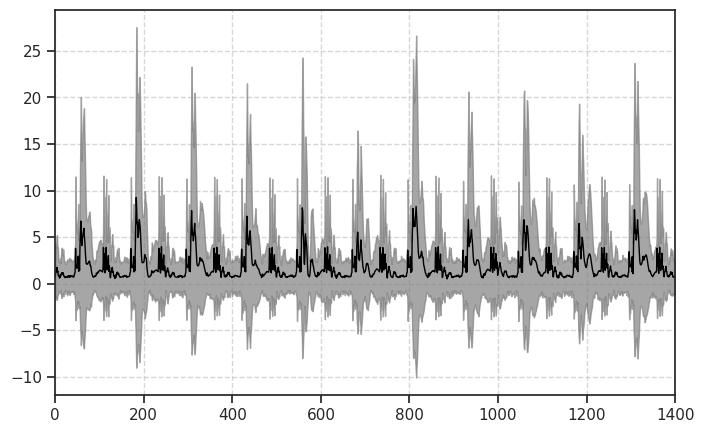

In [2]:
from scipy.signal import convolve
from sklearn.base import BaseEstimator, TransformerMixin, check_is_fitted


class HPFilter(BaseEstimator, TransformerMixin):
    def __init__(self, w=50):
        self.w = w
        self.kernel = (np.ones(w) / w)[:, None]

    def fit(self, X, y=None):
        self.running_mean_ = convolve(X, self.kernel, mode='same').mean(axis=0)
        return self

    def transform(self, X):
        check_is_fitted(self, 'running_mean_')
        return np.abs(X - self.running_mean_[None, :])


X_highpass = HPFilter(50).fit_transform(X)
fig, ax = plt.subplots(figsize=(8, 5))
plots.labs(ax, xlab='Feature index', ylabel='Value',
           title='High-pass filtered features (window=50)')
plots.plot_mean_std(X_highpass, ax=ax)

In [3]:
gs = []

for w in [5, 10, 20, 50, 100]:
    pl = make_pipeline(HPFilter(w), simplerf(SEED),)
    results = cv(SEED, pl, X, y, pts, ks, verbose=True)
    logging.info(f"[{w}]: {results['atk_score_mean'].mean():.4f}")

    gs.append(util.results_to_dict(results, w=w))
    util.save_results(gs, "feat_eng_hpfilter")

01:46:06: FOLD 1: PROF=0.3623; ATK=-0.0009
01:47:12: FOLD 2: PROF=0.3662; ATK=-0.0018
01:48:20: FOLD 3: PROF=0.3645; ATK=-0.0002
01:49:28: FOLD 4: PROF=0.3638; ATK=-0.0007
01:50:34: FOLD 5: PROF=0.3622; ATK=-0.0001
01:51:40: FOLD 6: PROF=0.3645; ATK=0.0000
01:52:48: FOLD 7: PROF=0.3673; ATK=-0.0016
01:53:52: FOLD 8: PROF=0.3655; ATK=-0.0024
01:54:55: FOLD 9: PROF=0.3651; ATK=-0.0006
01:55:58: FOLD 10: PROF=0.3617; ATK=-0.0005
[Parallel(n_jobs=1)]: Done 10 out of 10 | elapsed: 11.0min finished
01:55:58: [5]: -0.0009
01:56:56: FOLD 1: PROF=0.3623; ATK=-0.0009
01:57:52: FOLD 2: PROF=0.3664; ATK=-0.0017
01:58:48: FOLD 3: PROF=0.3645; ATK=-0.0002
01:59:45: FOLD 4: PROF=0.3638; ATK=-0.0007
02:00:44: FOLD 5: PROF=0.3623; ATK=-0.0001
02:01:41: FOLD 6: PROF=0.3638; ATK=0.0001
02:02:37: FOLD 7: PROF=0.3673; ATK=-0.0016
02:03:34: FOLD 8: PROF=0.3657; ATK=-0.0023
02:04:31: FOLD 9: PROF=0.3649; ATK=-0.0006
02:05:29: FOLD 10: PROF=0.3617; ATK=-0.0005
[Parallel(n_jobs=1)]: Done 10 out of 10 | elapsed

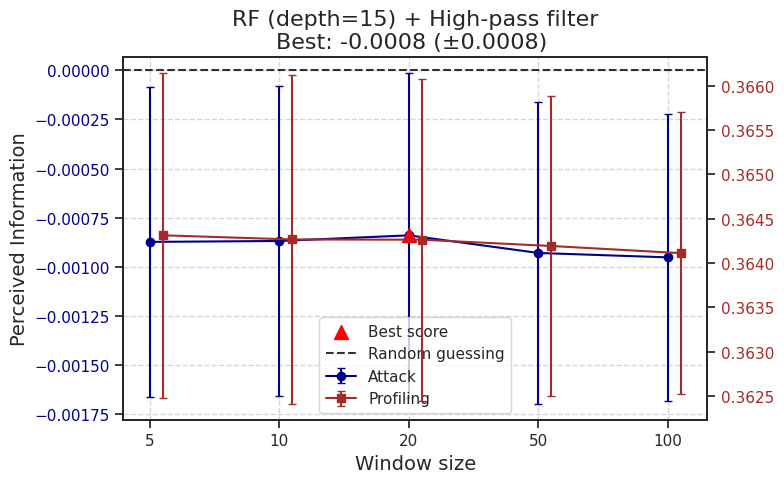

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
plots.plot_gs_results('feat_eng_hpfilter',
                  title='RF (depth=15) + High-pass filter',
                  key='w', ax=ax, xlab='Window size')
plots.savetight(fig, 'feat_eng_hpfilter')

Polynomial

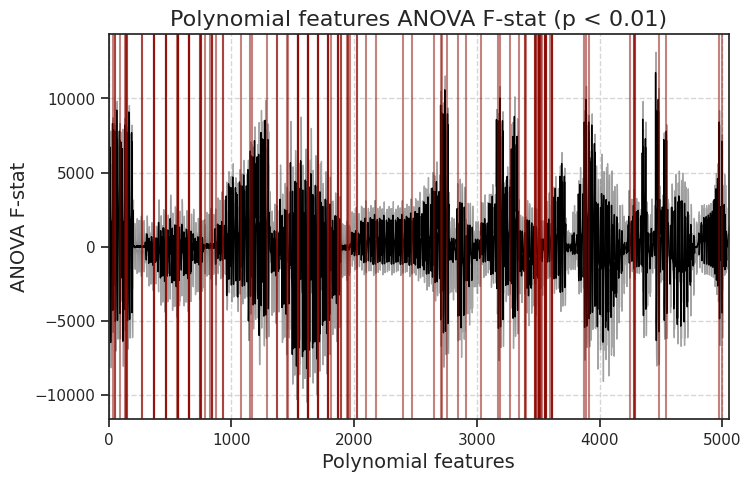

In [10]:
Xp, yp, *_ = splits_precomputed[0][0]

X_poly = PolynomialFeatures((2, 2), include_bias=False)\
    .fit_transform(Xp[:, :100])

fig, ax = plt.subplots(figsize=(8, 5))
plots.plot_mean_std(X_poly, ax=ax)
fstat, pval = f_classif(X_poly, yp)
fstat = fstat / np.max(fstat)

for i in np.where(pval < 0.01)[0]:
    ax.axvline(i, color='r', alpha=0.5)

plots.labs(ax, xlab='Polynomial features', ylab='ANOVA F-stat',
           title='Polynomial features ANOVA F-stat (p < 0.01)')

plots.savetight(fig, 'poly_fstat')

In [11]:
df_rf_poly_fscore = []

for k in [100, 200, 300, 500, 750, 1000]:
    pl_rf_poly_fscore = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree=(2, 2), include_bias=False, interaction_only=True),
        SelectKBest(f_classif, k=k),
        simplerf(SEED),
    )
    results = cv_precomputed(pl_rf_poly_fscore, splits_precomputed, verbose=False)
    logging.info(f"[{k}]: {results['atk_score_mean'].mean():.4f}")

    df_rf_poly_fscore.append(util.results_to_dict(results, k=k))
    util.save_results(df_rf_poly_fscore, "rf_poly_fscore")

03:09:25: [100]: 0.0396
03:16:23: [200]: 0.0457
03:23:50: [300]: 0.0552
03:32:09: [500]: 0.0760
03:41:48: [750]: 0.0792
03:52:19: [1000]: 0.0770


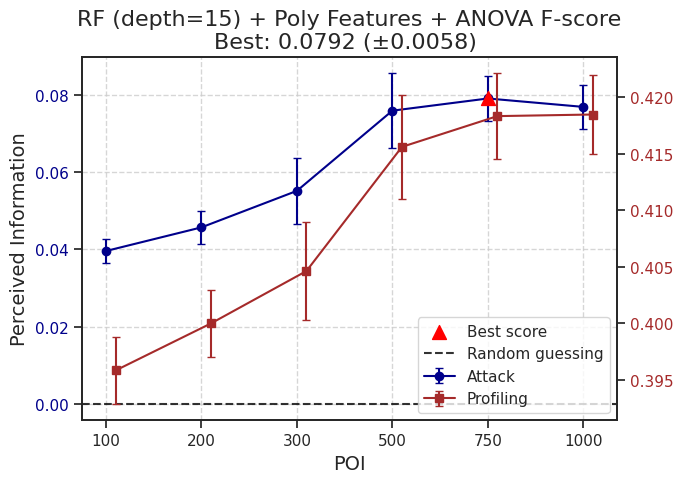

: 

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
plots.plot_gs_results('rf_poly_fscore', ax=ax,
                      key='k', loc='lower right',
                      title='RF (depth=15) + Poly Features + ANOVA F-score')
plots.savetight(fig, 'rf_poly_fscore')

In [13]:
pl = make_pipeline(
    SelectFromModel(simplerf(SEED), max_features=100),
    StandardScaler(),
    PolynomialFeatures(degree=(2, 2), include_bias=False, interaction_only=True),
    SelectKBest(f_classif, k=750),
)

In [14]:
X_poly = pl.fit_transform(X, y)

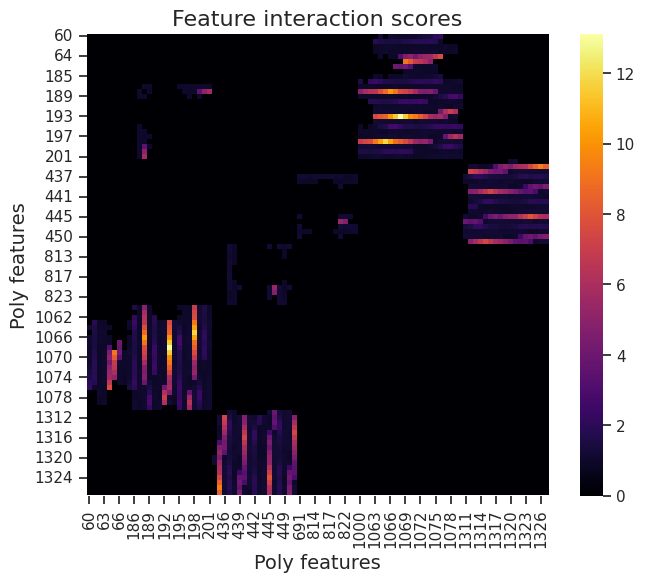

In [15]:
pl_info = util.inspect_pipeline(pl)
feats = pl_info['selected_features']

R = pd.DataFrame(np.zeros((len(feats), len(feats))), columns=feats, index=feats)

for (a, b), score in zip(pl_info['pairs'], pl_info['scores']):
    R.loc[a, b] = R.loc[b, a] = score

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(R, cmap='inferno', square=True, ax=ax)
plots.labs(ax, xlab='Poly features', ylab='Poly features', title='Feature interaction scores')
plots.savetight(fig, '06_poly_interactions')

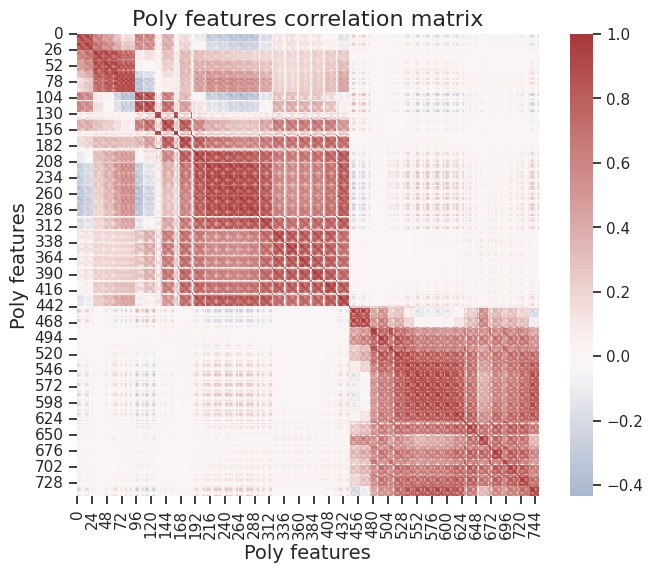

In [16]:
C = np.corrcoef(X_poly, rowvar=False)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(C, cmap='vlag', center=0, square=True, ax=ax)
plots.labs(ax, xlab='Poly features', ylab='Poly features', title='Poly features correlation matrix')
plots.savetight(fig, '06_poly_correlation')

In [17]:
splits_precomputed_poly = util.precompute_splits(SEED, pl, X, y, pts, ks, masks)
pickle.dump(splits_precomputed_poly, open("data/processed/splits_poly.pkl", "wb"))

  0%|          | 0/10 [00:00<?, ?it/s]